<h2 style="font-size: 24px;">IMPORTING FIRST 100 AUIDO FILES</h2>

In [1]:
import os
import pandas as pd
from pydub import AudioSegment


main_folder_path = r'C:\Users\xyz\Desktop\CapStone\augmented_dataset'

data = []


for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)
    
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path)[:100]:  #Collecting the first 100 audio files
            file_path = os.path.join(folder_path, file_name)
            audio = AudioSegment.from_wav(file_path)
            transcription = folder_name
            data.append((audio, transcription))

df = pd.DataFrame(data, columns=['audio', 'transcription'])
df.to_pickle('speech_dataset.pkl')

print(df.head(1000))


                                                 audio transcription
0    (((<pydub.audio_segment.AudioSegment object at...           bed
1    (((<pydub.audio_segment.AudioSegment object at...           bed
2    (((<pydub.audio_segment.AudioSegment object at...           bed
3    (((<pydub.audio_segment.AudioSegment object at...           bed
4    (((<pydub.audio_segment.AudioSegment object at...           bed
..                                                 ...           ...
995  (((<pydub.audio_segment.AudioSegment object at...         happy
996  (((<pydub.audio_segment.AudioSegment object at...         happy
997  (((<pydub.audio_segment.AudioSegment object at...         happy
998  (((<pydub.audio_segment.AudioSegment object at...         happy
999  (((<pydub.audio_segment.AudioSegment object at...         happy

[1000 rows x 2 columns]


<h2 style="font-size: 24px;">CREATING LABELS</h2>

In [2]:
label_names = [
    'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy',
    'house', 'left', 'marvel', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven',
    'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero'
]
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(label_names)


<h2 style="font-size: 24px;">SHUFFLE DATASET</h2>

In [3]:
import pandas as pd

shuffled_df = df.sample(frac=1).reset_index(drop=True)
print(shuffled_df.head())
shuffled_df.to_pickle('shuffled_dataset.pkl')


                                               audio transcription
0  (((<pydub.audio_segment.AudioSegment object at...         happy
1  (((<pydub.audio_segment.AudioSegment object at...           two
2  (((<pydub.audio_segment.AudioSegment object at...           two
3  (((<pydub.audio_segment.AudioSegment object at...           yes
4  (((<pydub.audio_segment.AudioSegment object at...           two


In [4]:
import pandas as pd
loaded_df = pd.read_pickle('shuffled_dataset.pkl')
print(loaded_df.head())

                                               audio transcription
0  (((<pydub.audio_segment.AudioSegment object at...         happy
1  (((<pydub.audio_segment.AudioSegment object at...           two
2  (((<pydub.audio_segment.AudioSegment object at...           two
3  (((<pydub.audio_segment.AudioSegment object at...           yes
4  (((<pydub.audio_segment.AudioSegment object at...           two


<h2 style="font-size: 24px;">SPLITTING DATASET</h2>

In [5]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(loaded_df, test_size=0.2, random_state=42)
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))


Training set size: 2400
Validation set size: 600


<h2 style="font-size: 24px;">CREATING WAVEFORMS</h2>

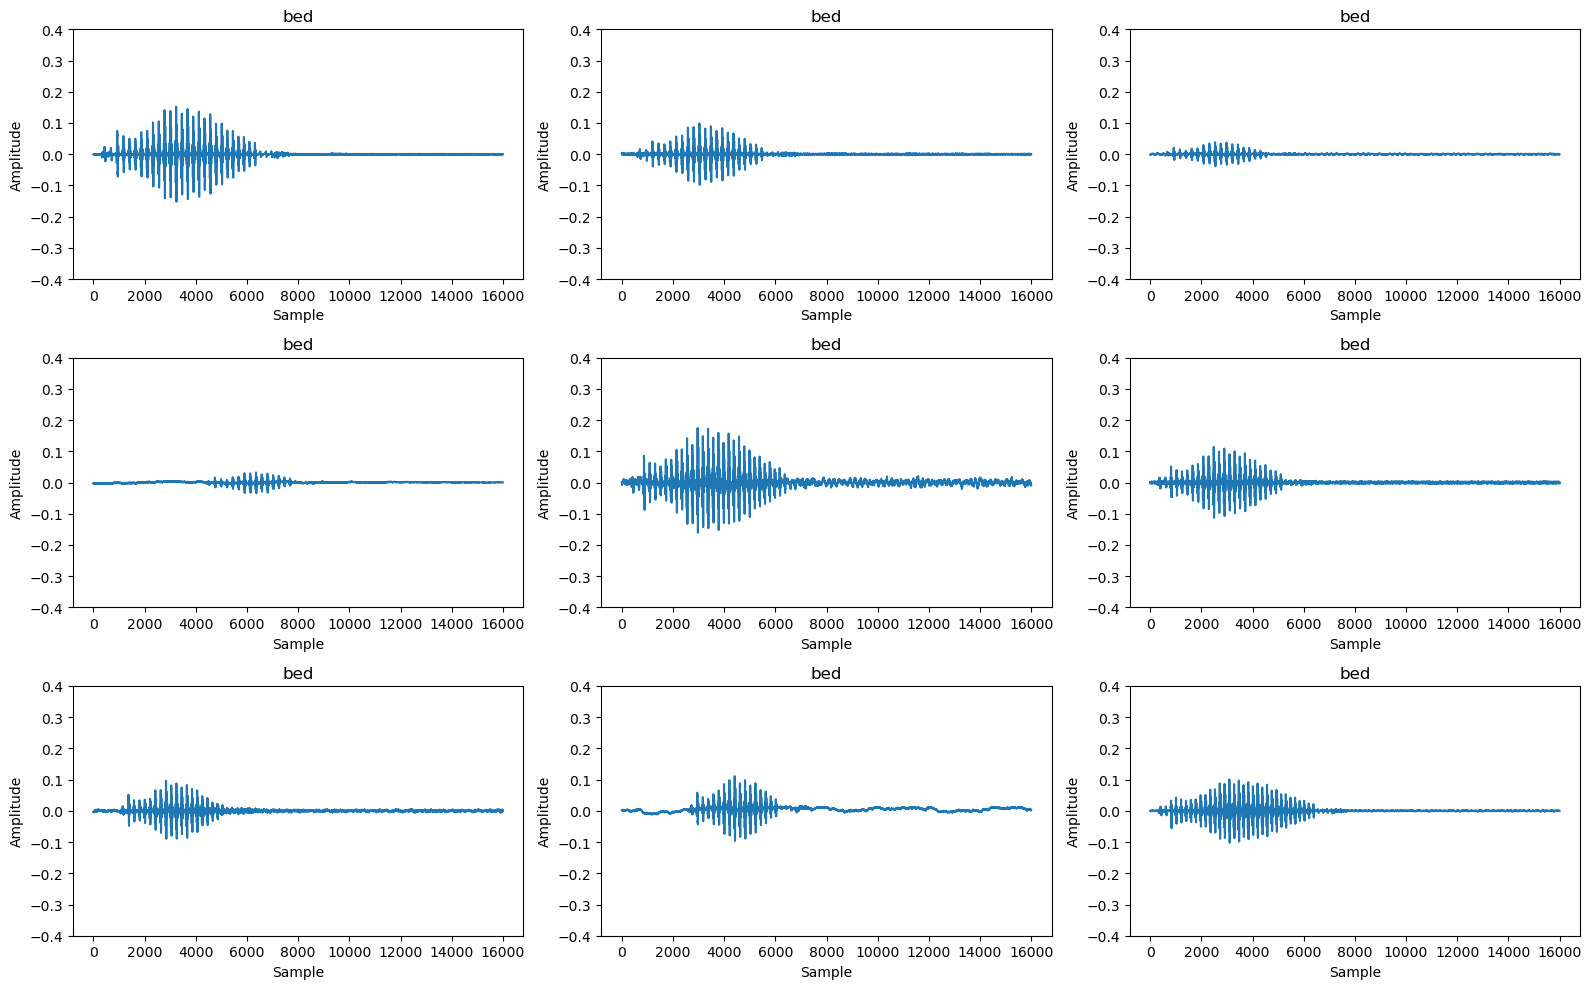

In [6]:
import matplotlib.pyplot as plt
import numpy as np

num_plots = 9

plt.figure(figsize=(16, 10))

for i in range(num_plots):
    plt.subplot(3, 3, i+1)  
    audio_signal = np.array(df['audio'][i].get_array_of_samples()) / (2**15)  #Normalize audio signal
    plt.plot(audio_signal)
    plt.title(df['transcription'][i])  #Use transcription as the title
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.ylim(-0.4, 0.4)  #Set y-axis limits to [-0.4, 0.4]
    plt.grid(False)  #Remove grid lines

plt.tight_layout()
plt.show()


In [7]:
import numpy as np

def extract_waveform(audio_segment):
    waveform = np.array(audio_segment.get_array_of_samples()) / (2 ** 15)  # Normalize audio signal
    return waveform

waveform_data = []
for i in range(len(df)):
    waveform = extract_waveform(df['audio'][i])
    waveform_data.append(waveform)

df['waveform'] = waveform_data


<h2 style="font-size: 24px;">CREATING SPECTROGRAMS FORM WAVEFORMS</h2>

In [8]:
import tensorflow as tf
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram
df['spectrogram_tf'] = df['waveform'].apply(get_spectrogram)


In [9]:
import IPython.display as display
num_examples = 3
for i in range(num_examples):
    label = df['transcription'][i]
    waveform = df['waveform'][i]
    spectrogram = get_spectrogram(waveform)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback:')
    display.display(display.Audio(waveform, rate=16000))


Label: bed
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback:


Label: bed
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback:


Label: bed
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback:


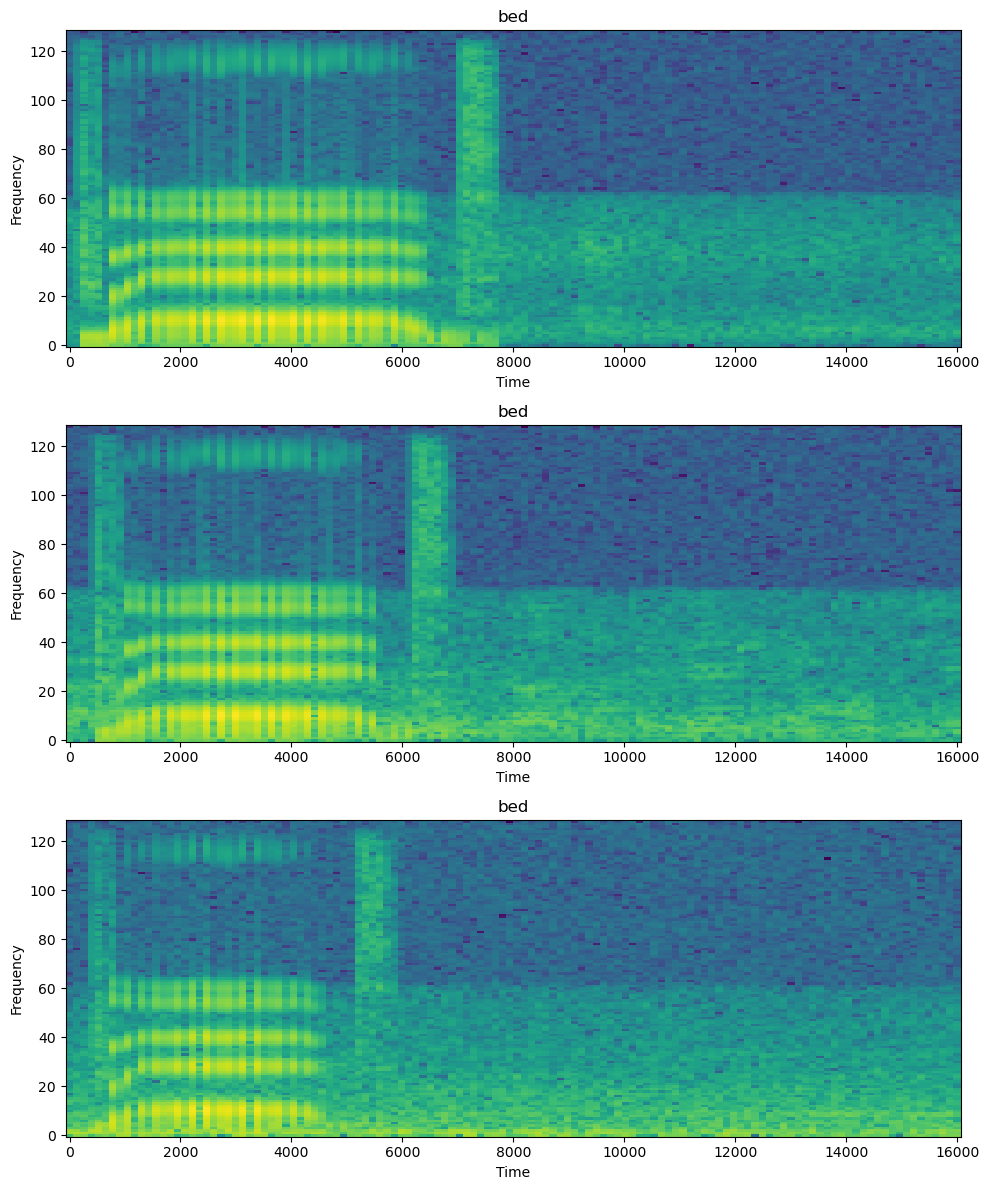

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for i in range(3):
    label = df['transcription'][i]
    spectrogram = df['spectrogram_tf'][i]
    plot_spectrogram(spectrogram, axes[i])
    axes[i].set_title(label)
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


In [11]:
df.to_pickle('dataframe.pkl')
df = pd.read_pickle('dataframe.pkl')

In [12]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))

Training set size: 2400
Validation set size: 600


<h2 style="font-size: 24px;">Convert waveform numpy arrays to TensorFlow tensors</h2>

In [13]:
import tensorflow as tf
import numpy as np

train_waveforms = [tf.convert_to_tensor(waveform) for waveform in train_df['waveform'].values]
val_waveforms = [tf.convert_to_tensor(waveform) for waveform in val_df['waveform'].values]

train_ds = tf.data.Dataset.from_tensor_slices((train_waveforms, train_df['transcription'].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_waveforms, val_df['transcription'].values))

def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)


In [14]:
df.columns

Index(['audio', 'transcription', 'waveform', 'spectrogram_tf'], dtype='object')

In [15]:
import numpy as np

def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = tf.squeeze(spectrogram, axis=-1)
    log_spec = tf.math.log(spectrogram + tf.keras.backend.epsilon())
    log_spec = tf.transpose(log_spec)  # Transpose operation using tf.transpose()
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)


In [16]:
print(df.head(10))

                                               audio transcription  \
0  (((<pydub.audio_segment.AudioSegment object at...           bed   
1  (((<pydub.audio_segment.AudioSegment object at...           bed   
2  (((<pydub.audio_segment.AudioSegment object at...           bed   
3  (((<pydub.audio_segment.AudioSegment object at...           bed   
4  (((<pydub.audio_segment.AudioSegment object at...           bed   
5  (((<pydub.audio_segment.AudioSegment object at...           bed   
6  (((<pydub.audio_segment.AudioSegment object at...           bed   
7  (((<pydub.audio_segment.AudioSegment object at...           bed   
8  (((<pydub.audio_segment.AudioSegment object at...           bed   
9  (((<pydub.audio_segment.AudioSegment object at...           bed   

                                            waveform  \
0  [0.0001220703125, 0.00042724609375, 0.00061035...   
1  [0.003875732421875, 0.00457763671875, 0.004211...   
2  [-0.0023193359375, -0.002532958984375, -0.0019...   
3  [-

In [17]:
df = pd.read_pickle('dataframe.pkl')
df = df.drop(columns=['audio', 'waveform'])
print(df.head(10))


  transcription                                     spectrogram_tf
0           bed  (((tf.Tensor(0.002373142137202097, shape=(), d...
1           bed  (((tf.Tensor(0.024623659112239, shape=(), dtyp...
2           bed  (((tf.Tensor(0.013016476751318588, shape=(), d...
3           bed  (((tf.Tensor(0.46783852333581044, shape=(), dt...
4           bed  (((tf.Tensor(0.29854711445920357, shape=(), dt...
5           bed  (((tf.Tensor(0.008250701088405699, shape=(), d...
6           bed  (((tf.Tensor(0.05746012927728694, shape=(), dt...
7           bed  (((tf.Tensor(0.21410811640786725, shape=(), dt...
8           bed  (((tf.Tensor(0.016203685990658842, shape=(), d...
9           bed  (((tf.Tensor(0.0005918748668328392, shape=(), ...


In [18]:
for index, row in df.iterrows():
    spectrogram = row['spectrogram_tf']
    print("Spectrogram shape:", spectrogram.shape)


<h2 style="font-size: 24px;"># Map transcription to label index</h2>
<h2 style="font-size: 24px;">CREATE MODEL ARCHITECTURE AND COMPILE THE MODEL</h2>

In [24]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_names = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy',
               'house', 'left', 'marvel', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven',
               'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(label_names)
df['labels'] = df['transcription'].map({label: index for index, label in enumerate(label_names)})

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(124, 129, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(label_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(df['spectrogram_tf'].values, df['labels'].values, test_size=0.2, random_state=42)

X_train = np.array([spectrogram.numpy() for spectrogram in X_train])
X_val = np.array([spectrogram.numpy() for spectrogram in X_val])

X_train = X_train.reshape(-1, 124, 129, 1)
X_val = X_val.reshape(-1, 124, 129, 1)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


C:\Users\xyz\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.3723 - loss: 2.3726 - val_accuracy: 0.8367 - val_loss: 0.6228
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.8804 - loss: 0.4266 - val_accuracy: 0.9050 - val_loss: 0.3419
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9480 - loss: 0.1770 - val_accuracy: 0.9100 - val_loss: 0.3524
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.9722 - loss: 0.1165 - val_accuracy: 0.9550 - val_loss: 0.1868
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9870 - loss: 0.0514 - val_accuracy: 0.9583 - val_loss: 0.1784
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.9935 - loss: 0.0262 - val_accuracy: 0.9583 - val_loss: 0.1859
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9939 - loss: 0.0320 - val_accuracy: 0.9617 - val_loss: 0.1620
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9964 - loss: 0.0185 - val_accuracy: 0.9750 - v

In [20]:
df.to_pickle('dataframe.pkl')

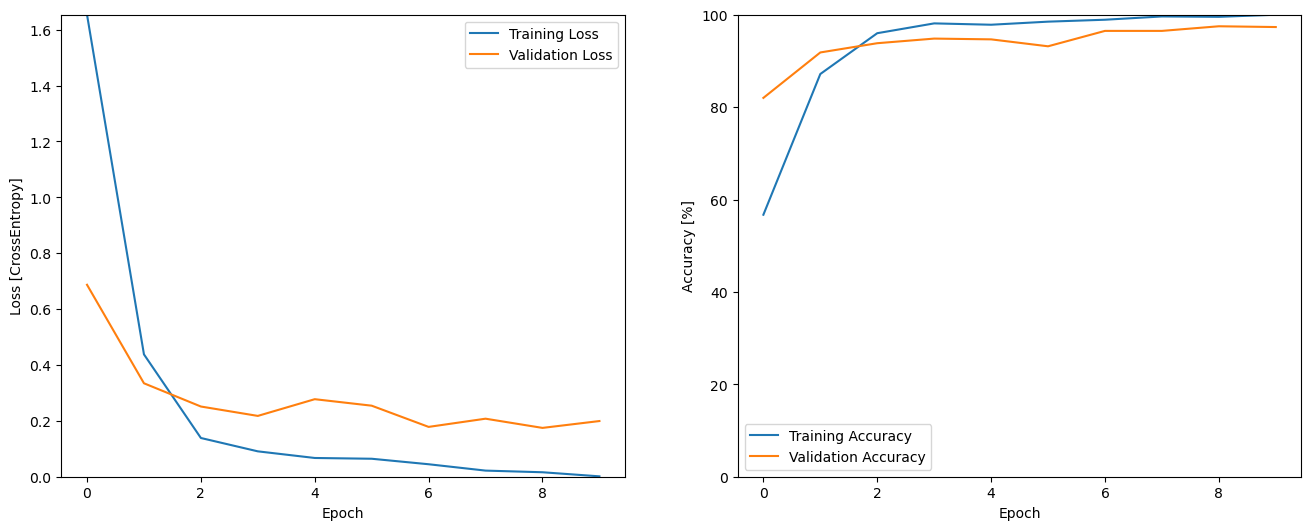

In [22]:
metrics = history.history
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], label='Training Loss')
plt.plot(history.epoch, metrics['val_loss'], label='Validation Loss')
plt.legend()
plt.ylim([0, max(max(metrics['loss']), max(metrics['val_loss']))])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), label='Training Accuracy')
plt.plot(history.epoch, 100*np.array(metrics['val_accuracy']), label='Validation Accuracy')
plt.legend()
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 122, 127, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 61, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 59, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 27, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 48384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,096,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,463,004 (36.10 MB)

 Trainable params: 3,154,334 (12.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,308,670 (24.07 MB)

In [25]:
# Conv2D layer 1
params_conv1 = (3 * 3 * 1 + 1) * 32

# Conv2D layer 2
params_conv2 = (3 * 3 * 32 + 1) * 64

# Conv2D layer 3
params_conv3 = (3 * 3 * 64 + 1) * 64

# Dense layer
params_dense = (64 + 1) * 64

# Output layer
params_output = (64 + 1) * len(label_names)

# Total number of parameters
total_params = params_conv1 + params_conv2 + params_conv3 + params_dense + params_output

print("Total number of parameters:", total_params)


Total number of parameters: 61854
